In [1]:
!conda install -c conda-forge librosa -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/pytorch_p36

  added / updated specs: 
    - librosa


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openh264-1.8.0             |    hdbcaa40_1000         1.4 MB  conda-forge
    ffmpeg-4.1.3               |       h167e202_0        75.8 MB  conda-forge
    libsndfile-1.0.28          |    he1b5a44_1000         529 KB  conda-forge
    python-3.6.7               |    h381d211_1004        34.5 MB  conda-forge
    joblib-0.14.1              |             py_0         198 KB  conda-forge
    glib-2.58.3                |    h6f030ca_1002         3.3 MB  conda-forge
    lame-3.100                 |    h14c3975_1001 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import soundfile as sf
#import sounddevice as sd
import queue
import boto3
import json
import io
import sklearn
import scipy.io.wavfile as sciwav

In [3]:
def extract_features(bucket, wav_key, feat='mfcc'):
    s3 = boto3.resource('s3')
    obj = s3.Object(bucket, wav_key)
    sample_rate, X = sciwav.read(io.BytesIO(obj.get()['Body'].read()))
    X = X.astype(np.float32)

    
    if feat == 'mfcc':
        features = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
    elif feat == 'mel':
        features = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_fft=1024, hop_length=256)
    else:
        raise Exception('feat must be "mfcc" or "mel"')
    
    return features

In [6]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket='music-ml-gigioli', Key='data/nsynth/nsynth-train/examples.json')

train_examples = json.loads(obj['Body'].read().decode('utf-8'))

In [161]:
# number of acoustic samples
len([k for k, v in train_examples.items() if v['instrument_source'] == 0])

102165

In [167]:
%%timeit
# how long it takes to extract one acoustic sample
_ = extract_features('music-ml-gigioli', 'data/nsynth/nsynth-train/audio/{}.wav'.format(k))

68.8 ms ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [4]:
# duration in hours
0.0688 * 102165 / 60 / 60

1.9524866666666667

In [166]:
mfccs = []
for i, x in enumerate(train_examples.items()):
    k, v = x
    mfccs.append(extract_features('music-ml-gigioli', 'data/nsynth/nsynth-train/audio/{}.wav'.format(k)))
    
    if i+1 % 1000 == 0:
        print(i+1)

KeyboardInterrupt: 

In [160]:
train_examples[list(train_examples.keys())[18]]

{'note': 281566,
 'sample_rate': 16000,
 'pitch': 92,
 'instrument_source': 2,
 'instrument_family_str': 'bass',
 'instrument_str': 'bass_synthetic_037',
 'note_str': 'bass_synthetic_037-092-050',
 'qualities_str': ['distortion'],
 'instrument_source_str': 'synthetic',
 'velocity': 50,
 'instrument_family': 0,
 'instrument': 443,
 'qualities': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]}

In [7]:
mfcc = extract_features(
    'music-ml-gigioli', 'data/nsynth/nsynth-train/audio/' + list(train_examples.keys())[12] + '.wav', 'mfcc'
)

In [162]:
(mfcc.nbytes * 102165) / (1e9)

2.0596464

In [26]:
mfcc.shape

(40, 126)

In [8]:
mfcc_norm = (mfcc - mfcc.min()) / (mfcc.max() - mfcc.min())

In [10]:
mfcc_norm

array([[1.        , 0.9569698 , 0.82021964, ..., 0.54006416, 0.54006416,
        0.54006416],
       [0.17692208, 0.17427774, 0.14848924, ..., 0.07117005, 0.07117005,
        0.07117005],
       [0.        , 0.00203744, 0.01367589, ..., 0.07117005, 0.07117005,
        0.07117005],
       ...,
       [0.05358678, 0.04990854, 0.03902034, ..., 0.07117005, 0.07117005,
        0.07117005],
       [0.0686168 , 0.06878196, 0.05992614, ..., 0.07117005, 0.07117005,
        0.07117005],
       [0.05198931, 0.05282843, 0.06393671, ..., 0.07117005, 0.07117005,
        0.07117005]], dtype=float32)

In [18]:
mfcc_scaled = sklearn.preprocessing.scale(mfcc, axis=1)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:180: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


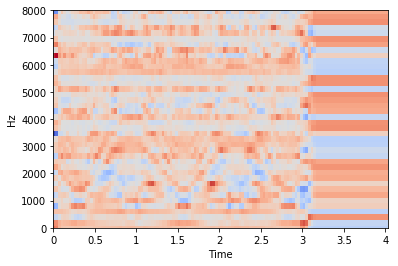

In [19]:
librosa.display.specshow(mfcc_scaled, sr=16000, x_axis='time', y_axis='hz')

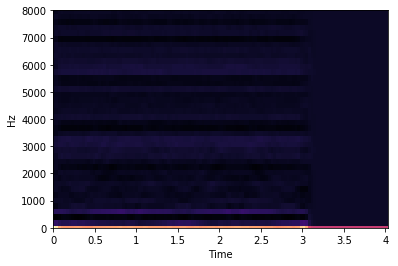

In [9]:
librosa.display.specshow(mfcc_norm, sr=16000, x_axis='time', y_axis='hz')

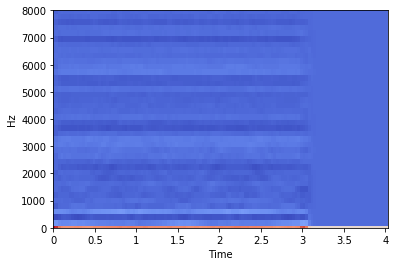

In [137]:
librosa.display.specshow(mfcc, sr=16000, x_axis='time', y_axis='hz')